**Key idea**: every
additional layer should more easily contain the identity function as one of its elements. 
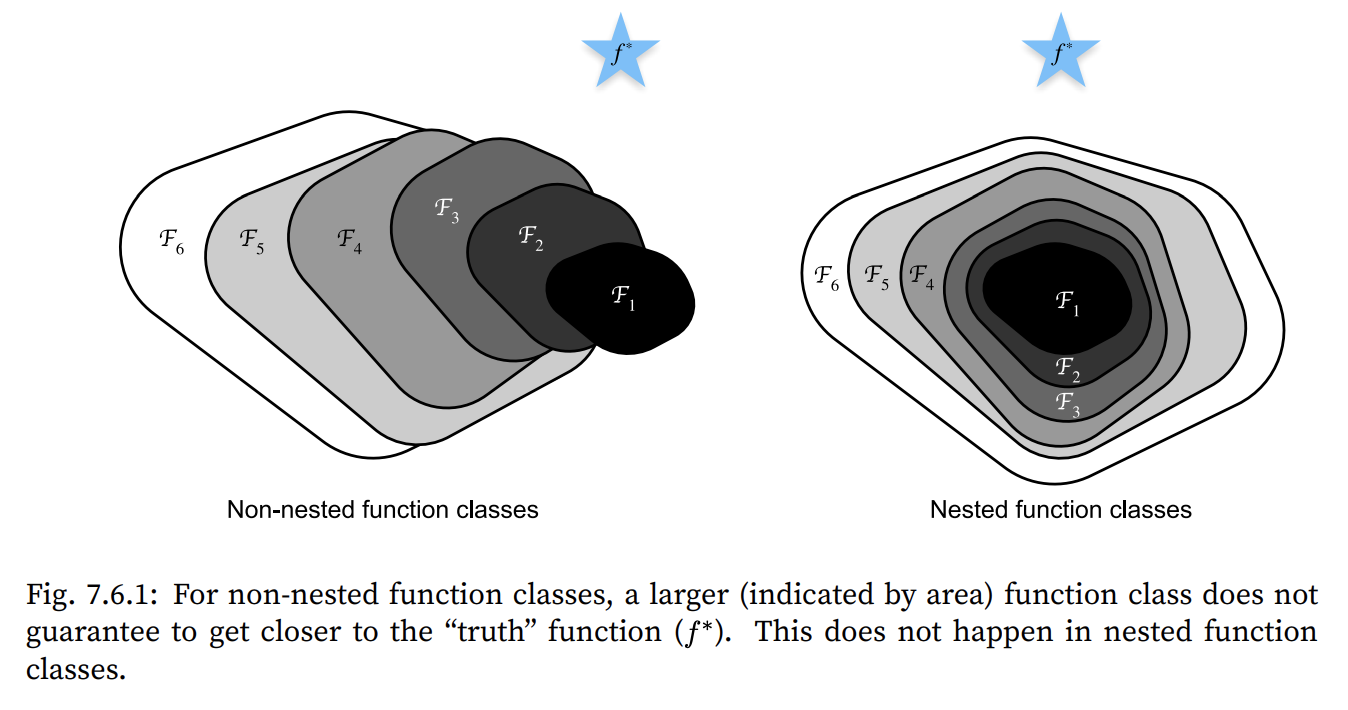

**Residual Blocks**  
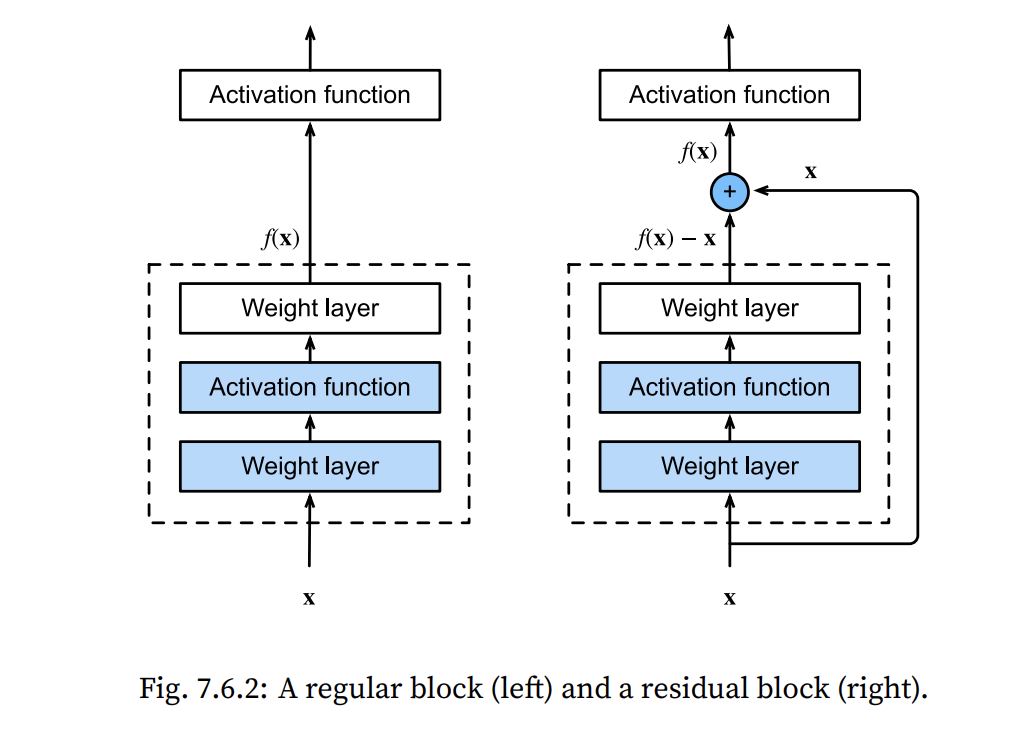

ResNet follows VGGʼs full $3 \times 3$ convolutional layer design. The residual block has two $3 \times 3$ convolutional layers with the same number of output channels. Each convolutional layer is followed
by a batch normalization layer and a ReLU activation function. Then, we skip these two convolution operations and add the input directly before the final ReLU activation function. This kind of
design requires that the output of the two convolutional layers has to be of the same shape as the
input, so that they can be added together. If we want to change the number of channels, we need to introduce an additional $1 \times 1$ convolutional layer to transform the input into the desired shape
for the addition operation

In [ ]:
!pip install d2l

In [3]:
import torch 
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

In [7]:
class Residual(nn.Module):
  def __init__(self, input_channels, num_channels, use_1x1conv=False, strides=1):
    super().__init__()
    self.conv1 = nn.Conv2d(input_channels, num_channels,
                           kernel_size=3, padding=1, stride=strides)
    self.conv2 = nn.Conv2d(num_channels, num_channels,
                           kernel_size=3, padding=1)
    if use_1x1conv:
      self.conv3 = nn.Conv2d(input_channels, num_channels,
                             kernel_size=1, stride=strides)
    else:
      self.conv3 = None
    self.bn1 = nn.BatchNorm2d(num_channels)
    self.bn2 = nn.BatchNorm2d(num_channels)
    
  def forward(self, X):
    Y = F.relu(self.bn1(self.conv1(X)))
    Y = self.bn2(self.conv2(Y))
    if self.conv3:
      X = self.conv3(X)
    Y += X
    return F.relu(Y)

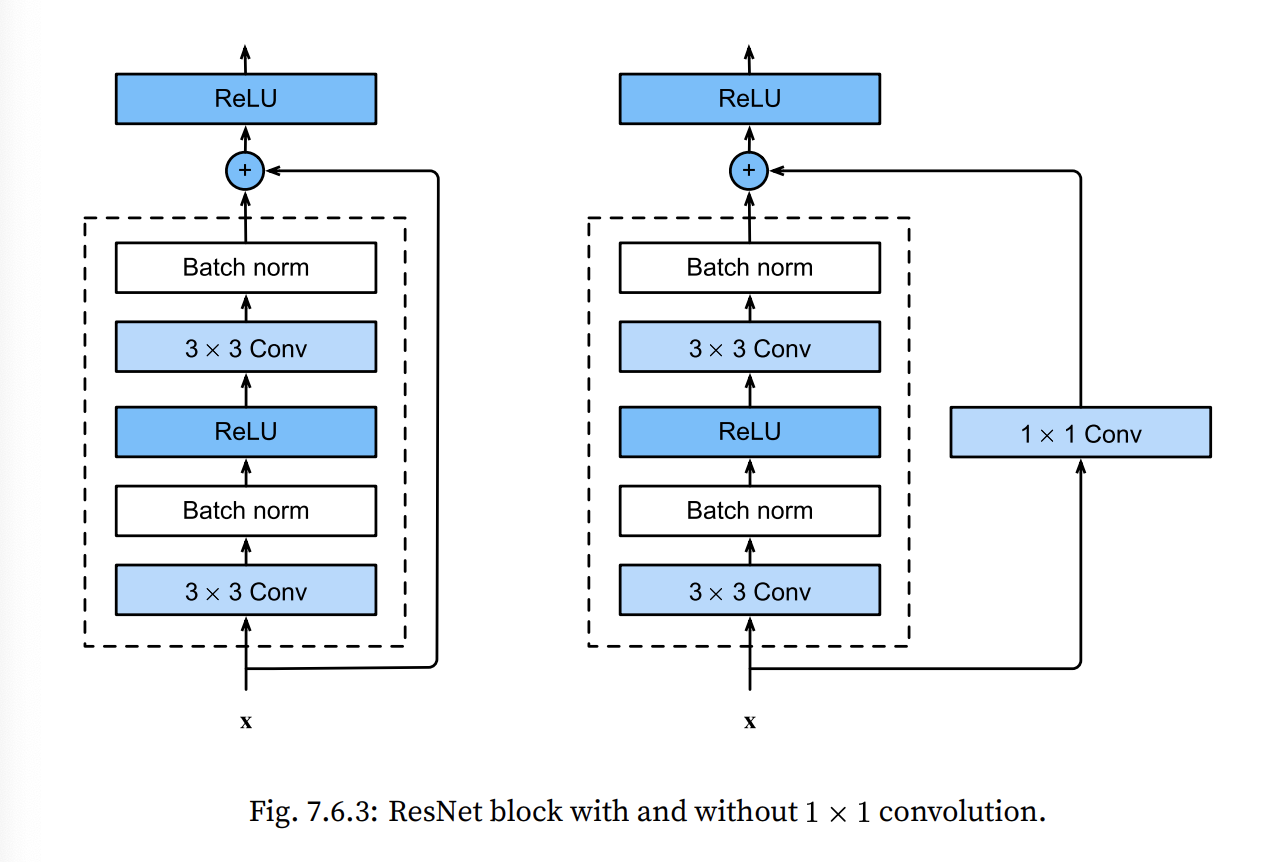

In [8]:
blk = Residual(3, 3)
X = torch.rand(4, 3, 6, 6)
Y = blk(X)
Y.shape

torch.Size([4, 3, 6, 6])

In [9]:
blk = Residual(3, 6, use_1x1conv=True, strides=2)
blk(X).shape

torch.Size([4, 6, 3, 3])

**ResNet Model**  
ResNet uses four modules
made up of residual blocks, each of which uses several residual blocks with the same number
of output channels. The number of channels in the first module is the same as the number of
input channels. In the first residual block for each of the subsequent
modules, the number of channels is doubled compared with that of the previous module, and the
height and width are halved.

In [15]:
def resnet_block(input_channels, num_channels, num_residuals, first_block=False):
  blk = []
  for i in range(num_residuals):
    if i == 0 and not first_block:
      blk.append(Residual(input_channels, num_channels, 
                          use_1x1conv=True, strides=2))
    else:
      blk.append(Residual(num_channels, num_channels))
  return blk

In [16]:
b1 = nn.Sequential(nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
                   nn.BatchNorm2d(64), nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
b2 = nn.Sequential(*resnet_block(64, 64, 2, first_block=True))
b3 = nn.Sequential(*resnet_block(64, 128, 2))
b4 = nn.Sequential(*resnet_block(128, 256, 2))
b5 = nn.Sequential(*resnet_block(256, 512, 2))

In [17]:
net = nn.Sequential(b1, b2, b3, b4, b5, 
                    nn.AdaptiveAvgPool2d((1, 1)),
                    nn.Flatten(), nn.Linear(512, 10))

In [18]:
X = torch.rand(1, 1, 224, 224)
for layer in net:
  X = layer(X)
  print(layer.__class__.__name__, 'output name:\t', X.shape)

Sequential output name:	 torch.Size([1, 64, 56, 56])
Sequential output name:	 torch.Size([1, 64, 56, 56])
Sequential output name:	 torch.Size([1, 128, 28, 28])
Sequential output name:	 torch.Size([1, 256, 14, 14])
Sequential output name:	 torch.Size([1, 512, 7, 7])
AdaptiveAvgPool2d output name:	 torch.Size([1, 512, 1, 1])
Flatten output name:	 torch.Size([1, 512])
Linear output name:	 torch.Size([1, 10])


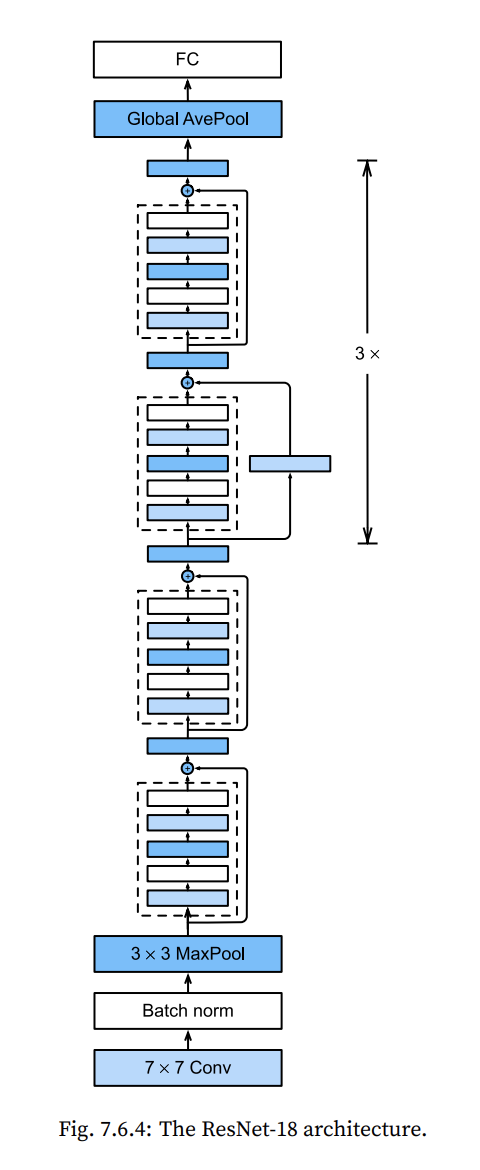

loss 0.015, train acc 0.996, test acc 0.914
2282.3 examples/sec on cuda:0


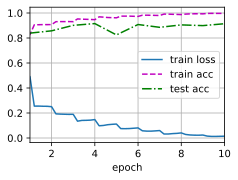

In [20]:
lr, num_epochs, batch_size = 0.05, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

**Summary**:
1. Nested function classes are desirable. Learning an additional layer in deep neural networks
as an identity function (though this is an extreme case) should be made easy.
2. The residual mapping can learn the identity function more easily, such as pushing parameters in the weight layer to zero.
3. We can train an effective deep neural network by having residual blocks. Inputs can forward
propagate faster through the residual connections across layers.
4. ResNet had a major influence on the design of subsequent deep neural networks, both for
convolutional and sequential nature.